### Install and import the required packages

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

In [3]:
# Installing cmdstanpy
t = time.time()
!pip install cmdstanpy
print('Time elapsed: {} seconds'.format(time.time() - t))

Time elapsed: 0.6446058750152588 seconds


In [4]:
# If cmdstan is not installed yet:
from cmdstanpy import install_cmdstan
install_cmdstan(verbose=True)

Installing CmdStan version: 2.32.2
Install directory: /Users/haoting/.cmdstan
CmdStan version 2.32.2 already installed


True

In [5]:
# If there is bug while running it on Apple Silicon, try the following:
from cmdstanpy import rebuild_cmdstan
rebuild_cmdstan()

 (00:00) |            | Building CmdStan                     

### Input your data of interest

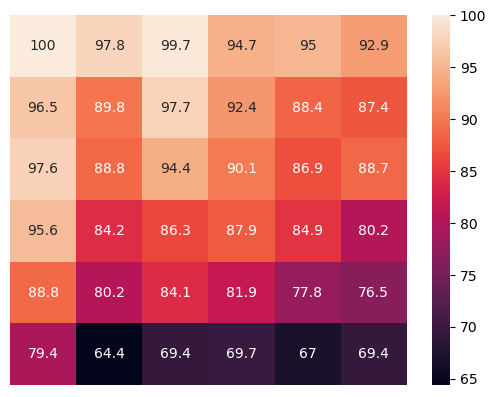

dosage 1:  [0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.03 0.03
 0.03 0.03 0.03 0.03 0.1  0.1  0.1  0.1  0.1  0.1  0.3  0.3  0.3  0.3
 0.3  0.3  1.   1.   1.   1.   1.   1.  ]
dosage 2:  [ 0.    0.75  2.5   7.5  25.   75.    0.    0.75  2.5   7.5  25.   75.
  0.    0.75  2.5   7.5  25.   75.    0.    0.75  2.5   7.5  25.   75.
  0.    0.75  2.5   7.5  25.   75.    0.    0.75  2.5   7.5  25.   75.  ]
response:  [100.   97.8  99.7  94.7  95.   92.9  96.5  89.8  97.7  92.4  88.4  87.4
  97.6  88.8  94.4  90.1  86.9  88.7  95.6  84.2  86.3  87.9  84.9  80.2
  88.8  80.2  84.1  81.9  77.8  76.5  79.4  64.4  69.4  69.7  67.   69.4]


In [6]:
# For example:
dose_mat = np.array([[100., 97.8, 99.7, 94.7, 95., 92.9],
                     [96.5, 89.8, 97.7, 92.4, 88.4, 87.4],
                     [97.6, 88.8, 94.4, 90.1, 86.9, 88.7],
                     [95.6, 84.2, 86.3, 87.9, 84.9, 80.2],
                     [88.8, 80.2, 84.1, 81.9, 77.8, 76.5],
                     [79.4, 64.4, 69.4, 69.7, 67., 69.4]])
agent1_mono_dose = np.array([0., 1e-2, 3e-2, 0.1, 0.3, 1.])
agent2_mono_dose = np.array([0., 7.5e-1, 2.5, 7.5, 25., 75.])
plt.figure()
sns.heatmap(dose_mat, annot=True, xticklabels=False, yticklabels=False, fmt='g')
plt.show()
X1 = np.repeat(agent1_mono_dose, 6)
X2 = np.tile(agent2_mono_dose, 6)
Y = np.reshape(dose_mat, (36))
print('dosage 1: ', X1)
print('dosage 2: ', X2)
print('response: ', Y)

In [ ]:
# Alternatively, upload dataset in the form of a .csv file, where the first 
# column is named "dosage_1", the second column is named "dosage_2", and the 
# third column is named "response".
df = pd.read_csv("your_dose_response_data.csv")
X1 = df["dosage_1"]
X2 = df["dosage_2"]
Y = df["response"]

### Define the model according to Box 2 in the paper

#### Notes:
 - The prior for $E_0$ is defined to be Gaussian with mean $100$ and a standard deviation of $3$ (i.e. $B=100$ where $B$ is defined in the paper). But this may need to be changed according to the range of the responses in the dataset. For example, if the response range is between $0$ and $1$, then the prior for $E_0$ below shall be changed from `e0 ~ normal(100, 3)` to `e0 ~ normal(1, 0.03)`. To do this, define `e0_mean = 1` in the cell below.
 - The Beta prior for the normalised $\text{E}_{\text{inf}}$ is defined according to Option 2 in the paper. To opt for Option 1, define `einf_beta_a = 1` and `einf_beta_b = 1` in the cell below so that we have `einf ~ beta(1, 1)` which is equivalent to `einf ~ uniform(0, 1)`.
 - The bounds for the prior of $\log C$ are defined according to the dosage range of the AstraZeneca-Sanger DREAM challenge. Please refer to the paper for information on how to adjust the bounds (`ic50_lb` and `ic50_ub` in the cell below) if necessary.
 - The prior for $\sigma$ (the standard deviation of the i.i.d. noise) is defined to be lognormal(0, 1), where $\mu=0$ controls the median of the prior. It can be tuned depending on the range of $Y$ and the noise level expected by the user. For example, when the range of $Y$ is between $0$ and $100$, then a lognormal(0, 1) gives a median of 1. But when the range of $Y$ is between $0$ and $1$, then a smaller $\mu$ (e.g. somewhere between -5 and -4) may be more suitable. This could be determined by empirically estimating the noise level from an external dataset. To tune this, change the value of `sigma_mu` in the cell below.

In [7]:
# Define the parameters for the prior distributions
e0_mean = 100
einf_beta_a = 0.46
einf_beta_b = 0.58
ic50_lb = 1e-10
ic50_ub = 1e6
sigma_mu = 0

#### Note: The following cell only needs to be run if you are working on Google Colab. If you are working locally, the following cell does not need to be run, as long as synba_combo.stan is already in the working directory.

In [ ]:
synba_combo = """data {
  int<lower=0> N;
  int<lower=0> N_test;
  vector[N] X1;
  vector[N] X2;
  vector[N] Y;
  vector[N_test] X1_test;
  vector[N_test] X2_test;
  real<lower=0> e0_mean;
  real<lower=0> einf_beta_a;
  real<lower=0> einf_beta_b;
  real log_ic50_lb;
  real log_ic50_ub;
  real sigma_mu;
}
parameters {
  real<lower=0> e_0;
  real<lower=0, upper=1> e_1;
  real<lower=0, upper=1> e_2;
  real<lower=0, upper=1> e_3;
  real<lower=log_ic50_lb, upper=log_ic50_ub> logC_1;
  real<lower=log_ic50_lb, upper=log_ic50_ub> logC_2;
  real<lower=0> h_1;
  real<lower=0> h_2;
  real<lower=0> alpha;
  real<lower=0> sigma;
}
model {
    e_0 ~ normal(e0_mean, 0.03*e0_mean);
    e_1 ~ beta(einf_beta_a, einf_beta_b);
    e_2 ~ beta(einf_beta_a, einf_beta_b);
    e_3 ~ beta(einf_beta_a, einf_beta_b);
    h_1 ~ lognormal(0, 1);
    h_2 ~ lognormal(0, 1);
    alpha ~ lognormal(0, 1);
    sigma ~ lognormal(sigma_mu, 1);
    for(i in 1:N){
        Y[i] ~ normal(((exp(logC_1))^h_1 * (exp(logC_2))^h_2 * e_0 + X1[i]^h_1 * (exp(logC_2))^h_2 * e_1 * e_0 + X2[i]^h_2 * (exp(logC_1))^h_1 * e_2 * e_0 + alpha * X1[i]^h_1 * X2[i]^h_2 * e_3 * e_0) / ((exp(logC_1))^h_1 * (exp(logC_2))^h_2 + X1[i]^h_1 * (exp(logC_2))^h_2 + X2[i]^h_2 * (exp(logC_1))^h_1 + alpha * X1[i]^h_1 * X2[i]^h_2), sigma);
    }
}
generated quantities {
    vector[N_test] Y_synthetic;
    for(i in 1:N_test){
        Y_synthetic[i] = normal_rng(((exp(logC_1))^h_1 * (exp(logC_2))^h_2 * e_0 + X1_test[i]^h_1 * (exp(logC_2))^h_2 * e_1 * e_0 + X2_test[i]^h_2 * (exp(logC_1))^h_1 * e_2 * e_0 + alpha * X1_test[i]^h_1 * X2_test[i]^h_2 * e_3 * e_0) / ((exp(logC_1))^h_1 * (exp(logC_2))^h_2 + X1_test[i]^h_1 * (exp(logC_2))^h_2 + X2_test[i]^h_2 * (exp(logC_1))^h_1 + alpha * X1_test[i]^h_1 * X2_test[i]^h_2), sigma);
    }
}"""

# THE PATH FOR GOOGLE COLAB:
file_path = '/content/synba_combo.stan'

with open(file_path, 'w') as file:
    file.write(synba_combo)

# Print the file path
print("File saved:", file_path)

### Compile and train the model

In [8]:
# Compile the model
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file='synba_combo.stan')
print('Time taken to compile the model: {} seconds'.format(time.time() - t))

Time taken to compile the model: 279.2628481388092 seconds


In [9]:
# Fit the model and generate samples
t = time.time()
N = len(Y)
# Add a tiny value to the zeros.
zero_ind = np.where(X1 == 0)[0]
X1[zero_ind] = np.minimum(1e-8, 0.001 * np.min(X1[np.where(X1>0)[0]]))
zero_ind = np.where(X2 == 0)[0]
X2[zero_ind] = np.minimum(1e-8, 0.001 * np.min(X2[np.where(X2>0)[0]]))
# Define data
data = {'N': N, 'X1': X1, 'X2': X2, 'Y': Y,
        'N_test': N, 'X1_test': X1, 'X2_test': X2,
        'e0_mean': e0_mean, 'einf_beta_a': einf_beta_a, 'einf_beta_b': einf_beta_b,
        'log_ic50_lb': np.log(ic50_lb), 'log_ic50_ub': np.log(ic50_ub), 'sigma_mu': sigma_mu}
fit = model.sample(data=data)
print('Time taken to compile the model: {} seconds'.format(time.time() - t))

12:34:23 - cmdstanpy - INFO - CmdStan start processing
12:34:35 - cmdstanpy - INFO - CmdStan done processing.
12:34:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is nan, but must be finite! (in '/Users/haoting/Documents/GitHub/SynBa/synba_combo.stan', line 38, column 8 to column 346)
	Exception: normal_lpdf: Location parameter is nan, but must be finite! (in '/Users/haoting/Documents/GitHub/SynBa/synba_combo.stan', line 38, column 8 to column 346)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/haoting/Documents/GitHub/SynBa/synba_combo.stan', line 38, column 8 to column 346)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/haoting/Documents/GitHub/SynBa/synba_combo.stan', line 38, column 8 to column 346)
	Exception: normal_lpdf: Location parameter is nan, but must be finite! (in '/Users/haoting/Documents/GitHub/SynBa/synba_combo.stan', line 38, column 8 to co

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Time taken to compile the model: 12.193438053131104 seconds


### Output Analysis

#### Summary statistics

Note: The "e_1", "e_2" and "e_3" in the summary table are normalised, so their ranges are (0, 1) instead of (0, e_0).

In [10]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-57.250400,0.097899,2.868420,-62.710200,-56.832100,-53.291600,858.484,45.9058,1.008480
e_0,100.891000,0.041492,1.889380,97.865200,100.844000,104.042000,2073.530,110.8780,1.000900
e_1,0.256759,0.005815,0.234630,0.001680,0.196326,0.696989,1627.810,87.0443,1.003760
e_2,0.822489,0.009079,0.209450,0.288259,0.909361,0.972457,532.247,28.4609,1.003150
e_3,0.159036,0.003801,0.163737,0.000791,0.101876,0.474290,1856.060,99.2494,1.001660
logC_1,1.780220,0.030302,1.053740,-0.077908,1.849880,3.313640,1209.280,64.6640,1.002910
logC_2,-1.564460,0.336717,9.852520,-17.611200,-1.513000,12.864100,856.180,45.7826,1.005790
h_1,0.579062,0.002479,0.090659,0.457291,0.566730,0.747149,1336.990,71.4929,1.002070
h_2,0.731480,0.041819,1.645670,0.097276,0.247990,2.777630,1548.610,82.8088,1.002040
alpha,2.182090,0.038891,1.672100,0.597712,1.776030,5.171900,1848.530,98.8464,1.000100


In [11]:
# Extracting traces
e0, e1, e2, e3 = fit.stan_variable('e_0'), fit.stan_variable('e_1'), fit.stan_variable('e_2'), fit.stan_variable('e_3')
logC1, logC2, h1, h2 = fit.stan_variable('logC_1'), fit.stan_variable('logC_2'), fit.stan_variable('h_1'), fit.stan_variable('h_2')
alpha, sigma = fit.stan_variable('alpha'), fit.stan_variable('sigma')

#### Visualisation of the synergy

1. The contour plot for the joint posterior distribution of the synergistic efficacy (ΔHSA) and the synergistic potency (log(α)). The distribution is smoothed from the empirical posterior with a kernel density estimation for visualisation purpose.

2. The histogram of the synergistic efficacy (ΔHSA). The area on the right hand side of the red vertical line is the probability that the combination is synergistic in terms of efficacy.

3. The histogram of synergistic potency (log(α)). The area on the right hand side of the red vertical line is the probability that the combination is synergistic in terms of potency.

First quadrant: The combination is synergistic in terms of both potency and efficacy.
Second quadrant: The combination is synergistic in terms of efficacy but not potency.
Third quadrant: The combination is synergistic in terms of potency but not efficacy.
Fourth quadrant: The combination is not synergistic in terms of either potency or efficacy.
P(the combination is synergistic in terms of both potency and efficacy) = 47.72%
P(the combination is synergistic in terms of efficacy but not potency) = 15.27%
P(the combination is synergistic in terms of potency but not efficacy) = 35.51%
P(the combination is not synergistic in terms of either potency or efficacy) = 1.50%
P(the combination is synergistic in terms of efficacy) = P(Delta HSA>0) = 62.99%
P(the combination is synergistic in terms of potency) = P(alpha>1) = 83.23%


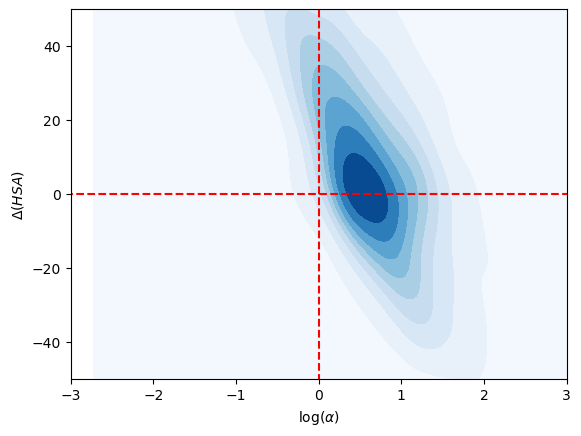

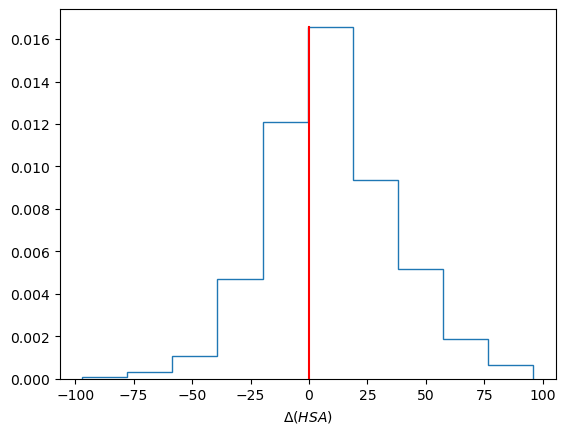

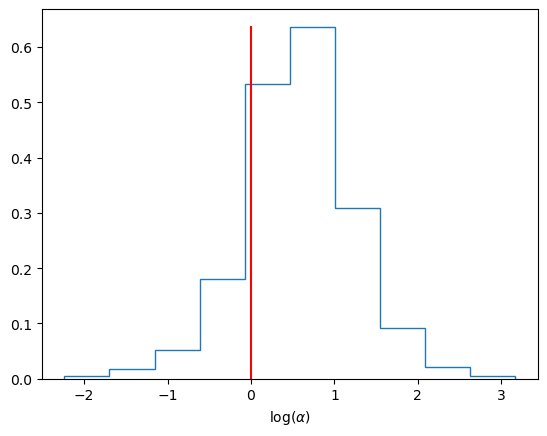

In [12]:
# Plot the posterior
delta_hsa = e0 * (np.minimum(e1, e2) - e3)

print('First quadrant: The combination is synergistic in terms of both potency and efficacy.')
print('Second quadrant: The combination is synergistic in terms of efficacy but not potency.')
print('Third quadrant: The combination is synergistic in terms of potency but not efficacy.')
print('Fourth quadrant: The combination is not synergistic in terms of either potency or efficacy.')

sns.kdeplot(x=np.log(alpha), y=delta_hsa, cmap="Blues", fill=True, # shade=True, shade_lowest=False,
            thresh=0, clip=((-5, 5), (-100, 100)))
sns.lineplot(x=[-5, 5], y=[0, 0], color='r', linewidth=1.5, linestyle='--')
sns.lineplot(x=[0, 0], y=[-100, 100], color='r', linewidth=1.5, linestyle='--', estimator=None)
plt.xlabel(r'$\log(\alpha)$')
plt.ylabel(r'$\Delta(HSA)$')
plt.xlim([-3, 3])
plt.ylim([-50, 50])
plt.show()

delta_hsa = 100 * (np.minimum(e1[1000:-1], e2[1000:-1]) - e3[1000:-1])
alpha_vec = alpha[1000:-1]

print('P(the combination is synergistic in terms of both potency and efficacy) = {:.2f}%'.format(
      100*len(np.intersect1d(np.where(delta_hsa > 0)[0], np.where(alpha_vec > 1)[0]))/len(delta_hsa)))
print('P(the combination is synergistic in terms of efficacy but not potency) = {:.2f}%'.format(
      100*len(np.intersect1d(np.where(delta_hsa > 0)[0], np.where(alpha_vec < 1)[0]))/len(delta_hsa)))
print('P(the combination is synergistic in terms of potency but not efficacy) = {:.2f}%'.format(
      100*len(np.intersect1d(np.where(delta_hsa < 0)[0], np.where(alpha_vec > 1)[0]))/len(delta_hsa)))
print('P(the combination is not synergistic in terms of either potency or efficacy) = {:.2f}%'.format(
      100*len(np.intersect1d(np.where(delta_hsa < 0)[0], np.where(alpha_vec < 1)[0]))/len(delta_hsa)))

plt.plot()
val, _, _ = plt.hist(delta_hsa, density=True, histtype='step')
plt.plot([0, 0], [0, np.max(val)], color='r')
plt.xlabel(r'$\Delta(HSA)$')
plt.show()

print('P(the combination is synergistic in terms of efficacy) = P(Delta HSA>0) = {:.2f}%'.format(
      100*len(np.where(delta_hsa > 0)[0])/len(delta_hsa)))

plt.plot()
val, _, _ = plt.hist(np.log(alpha_vec), density=True, histtype='step')
plt.plot([0, 0], [0, np.max(val)], color='r')
plt.xlabel(r'$\log(\alpha)$')
plt.show()

print('P(the combination is synergistic in terms of potency) = P(alpha>1) = {:.2f}%'.format(
      100*len(np.where(alpha_vec > 1)[0])/len(alpha_vec)))